Units removed for faster computing, creates heatmap only

In [93]:
%matplotlib notebook

from modsim import *

In [101]:
condition = Condition(x = 0, 
                      y = 0,
                      g = 9.8,
                      mass = 1e-3,
                      diameter = 1e-2,
                      rho = 1.2,
                      C_d = .67,
                      angle = 0,
                      velocity = 10,
                      duration = 50)

In [102]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, rel_vy = pol2cart(theta, velocity)
    abs_vy = rel_vy + 53
    
    # make the initial state
    init = State(x=x, abs_y=y, rel_y=y, vx=vx, abs_vy=abs_vy, rel_vy = rel_vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 400)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, abs_y, rel_y, vx, abs_vy, rel_vy = state
    unpack(system)
    
    f_drag_x = -rho * vx**2 * C_d * area / 2
    a_x = f_drag_x / mass
    
    f_drag_y = -rho * abs_vy**2 * C_d * area / 2
    a_y = f_drag_y / mass + g
    
    vx = vx + (a_x * t)
    abs_vy = abs_vy + (a_y * t)
    rel_vy = abs_vy - 53
    
    return vx, abs_vy, rel_vy, a_x, a_y, a_y

In [103]:
system = make_system(condition)
slope_func(system.init, 0, system)
run_odeint(system, slope_func)

In [104]:
#Absolute
xs = system.results.x
abs_ys = -system.results.abs_y
vxs = system.results.vx
abs_vys = system.results.abs_vy

#Relative
xs = system.results.x
rel_ys = -system.results.rel_y
vxs = system.results.vx
rel_vys = system.results.rel_vy

In [105]:
def calc_miss(angle, distance):
    condition.set(angle = angle)
    system = make_system(condition)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    T = interp_inverse(xs, kind='cubic')
    hit_time = T(distance)
    print(hit_time)
    hit_height = y_series(hit_time)

    print(hit_height)
    
def plot_rel_path(angle):
    condition.set(angle = angle)
    system = make_system(condition)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    plot(xs, rel_ys, label= str(-angle) + ' degrees')
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Relative Trajectory of Dart',
             xlim=[0, 1.5],
             ylim=[-.5, 1])
    
def plot_abs_path(angle):
    condition.set(angle = angle)
    system = make_system(condition)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')

    plot(xs, abs_ys)

    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Absolute Trajectory of Dart Shot at 0 Degrees',
             xlim=[0, 20],
             ylim=[-20, 0])

def plot_abs_vel(angle):
    condition.set(angle = angle)
    system = make_system(condition)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')

    plot(ts, abs_vys)

    decorate(xlabel='Time (s)',
             ylabel='y velocity (m)',
             title='Absolute Velocity of Dart Shot at 0 Degrees',
             xlim=[0, 20],
             ylim=[0,53])

In [106]:
def hit_or_miss(angle, distance, height):
    hit = State(None)
    
    condition.set(angle = angle)
    system = make_system(condition)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    T = interp_inverse(xs, kind='cubic')
    hit_time = T(distance)
    hit_height = y_series(hit_time)
    
    error = abs(hit_height-height)
        
    return error

def calc_trajectory(distance, height, printing, low, high):
    ideal = min_bounded(hit_or_miss, [low, high], distance, height)
    if printing == True:
        print (ideal)
    else:
        return ideal
    
def plot_shot(angle, distance, height):
    condition.set(angle = angle)
    system = make_system(condition)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    plot(xs, rel_ys, label="Path") #'Path: '+str(-angle)+' deg. angle'
    plot(distance, height, marker = 'X', markersize = 20, color = 'r', label = 'Target')
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Dart path shot at -16 degrees',
             xlim=[0, distance + .4],
             ylim=[-.4, height + .4])
    
def plot_point(angle, distance, height, hit_or_miss, color):
    result = hit_or_miss(angle, distance, height)
    if result < .1:
        plot(distance, height, color)

distances = linspace(.5,3,20)
heights = linspace(0,8,20)
angles = linspace(-60,60,7)
colors = ['rs', 'ms', 'bs', 'ks', 'cs', 'gs', 'ys']

def sweep_trajectory(angles, distances, heights, colors):
    for height in heights:
        for distance in distances:
            for angle, color in zip(angles, colors):
                plot_point(angle, distance, height, hit_or_miss, color)
                
distances = linspace(.5,4,60)
heights = linspace(0,3,4)
colors = ['r-', 'b-', 'g-', 'k-']
colors2 = ['r:', 'b:', 'g:', 'k:']
colors3 = ['r', 'b', 'g', 'k']
    
def create_line(distances, heights, colors, low, high):
    for height, color in zip(heights, colors):
        sweep = SweepSeries()
        for distance in distances:
            ideal = calc_trajectory(distance, height, False, low, high)
            if ideal.fun <.2:
                sweep[distance] = -1 * ideal.x
        plot(sweep, color)
        
def plot_error(height, distances, colors, low, high):
    for height, color in zip(heights, colors):
        sweep = SweepSeries()
        for distance in distances:
            ideal = calc_trajectory(distance, height, False, low, high)
            error = hit_or_miss(ideal.x, distance, height)
            sweep[distance] = error
        plot(sweep, color = color, label = str(height) + 'm above')

<IPython.core.display.Javascript object>


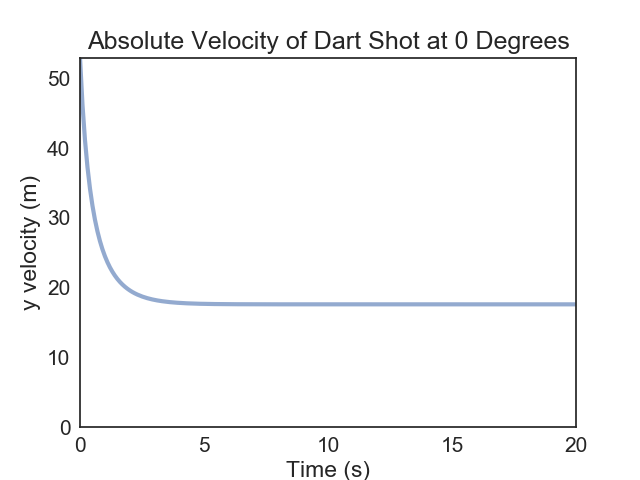

Saving figure to file abs_vel.pdf


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<IPython.core.display.Javascript object>


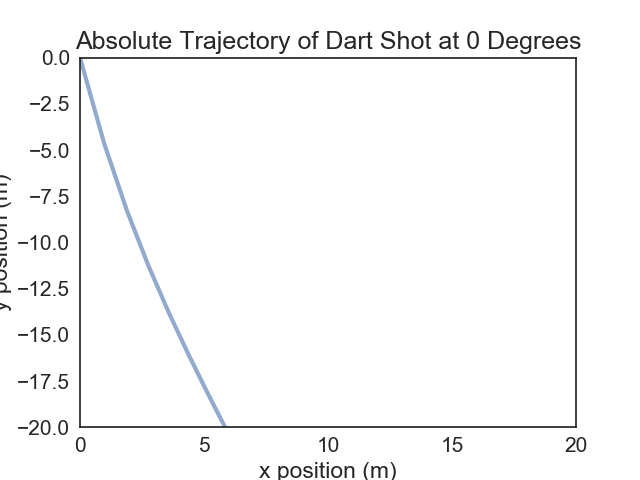

Saving figure to file abs_path.pdf


In [100]:
newfig()
plot_abs_vel(0)
savefig('abs_vel.pdf')
newfig()
plot_abs_path(0)
savefig('abs_path.pdf')

<IPython.core.display.Javascript object>


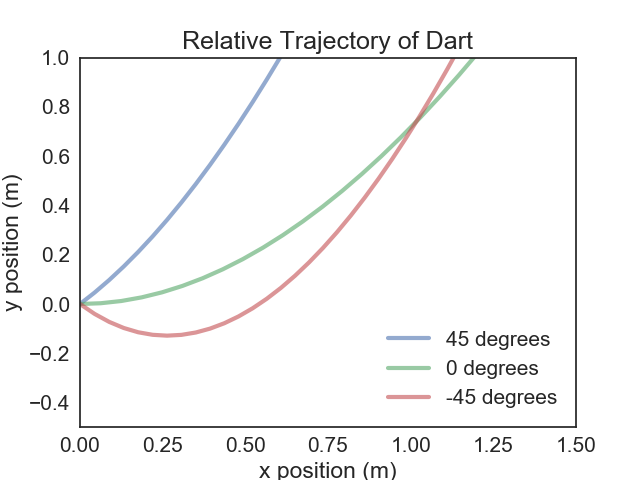

Saving figure to file rel_path.pdf


In [90]:
newfig()
plot_rel_path(-45)
plot_rel_path(0)
plot_rel_path(45)
savefig('rel_path.pdf')

<IPython.core.display.Javascript object>


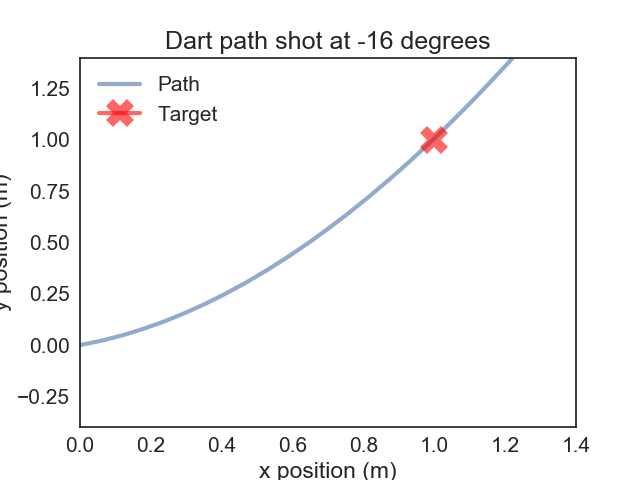

Saving figure to file example_shot.pdf


In [91]:
newfig()
plot_shot(-17, 1, 1)
savefig('example_shot.pdf')


<IPython.core.display.Javascript object>


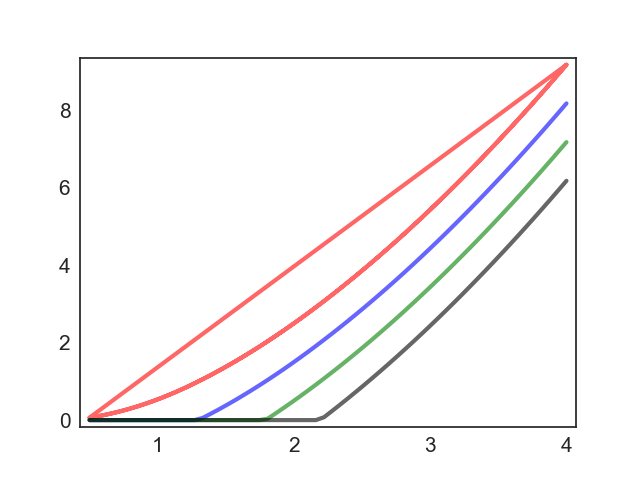

In [ ]:
newfig()
for height in heights:
    plot_error(height, distances, colors3, -89, 22)

decorate(xlabel='Distance to target (m)',
        ylabel='Error (m)',
        title='Least error given target height')

savefig('error_fig.pdf')

In [ ]:
newfig()
create_line(distances, heights, colors, 5, 89)
create_line(distances, heights, colors2, -89, 40)
decorate(xlabel='X distance to target (m)',
        ylabel='Angle (degrees)',
        title='Ideal Angle')
savefig('ideal_angles.pdf')